### Exploratory Data Analysis

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
data = pd.read_parquet("bank_data.parquet")

In [41]:
data.head(5)

,ZIBZIN,IDAvisAutorisationCheque,FlagImpaye,Montant,DateTransaction,CodeDecision,VerifianceCPT1,VerifianceCPT2,VerifianceCPT3,D2CB,...,TauxImpNb_RB,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr1,DiffDateTr2,DiffDateTr3,CA3TRetMtt,CA3TR,Heure
0,A013010004908126703060931,78643044,0,20.00,2017-02-01 07:32:14,1,0,0,0,551,...,37.186668,52.076034,0,1,4.000000,4.0,4.0,20.00,0.00,27134
1,A013011306908024927155000,78643045,0,20.00,2017-02-01 07:43:37,1,0,0,0,551,...,48.844716,52.076034,1,2,1.797685,4.0,4.0,28.61,8.61,27817
2,A013010002908283134592527,78643046,0,57.64,2017-02-01 07:47:38,1,0,0,0,549,...,73.118280,52.076034,0,1,4.000000,4.0,4.0,57.64,0.00,28058
3,A011010002908105209831316,78643047,0,54.29,2017-02-01 07:48:48,0,1,1,1,267,...,110.056926,53.554234,0,1,4.000000,4.0,4.0,54.29,0.00,28128
4,A013010041908000125652029,78643048,0,26.90,2017-02-01 08:13:27,1,0,0,0,549,...,45.368313,52.076034,1,1,1.997106,4.0,4.0,59.15,32.25,29607


In [42]:
data.shape

(4646773, 23)

In [43]:
# Check fraud distribution
fraud_ratio = data['FlagImpaye'].value_counts(normalize=True)
print("\n🔹 Fraud Class Distribution:\n", fraud_ratio)


🔹 Fraud Class Distribution:
 FlagImpaye
0    0.993545
1    0.006455
Name: proportion, dtype: float64


Train/Test Split Based on Date

In [44]:
import duckdb as ddb

# Split dataset according to the given period (Feb 2017 - Nov 2017)
train_df = ddb.query("SELECT * FROM data WHERE DateTransaction <= '2017-08-31'").df()
test_df = ddb.query("SELECT * FROM data WHERE DateTransaction >= '2017-09-01'").df()

Data Exploration

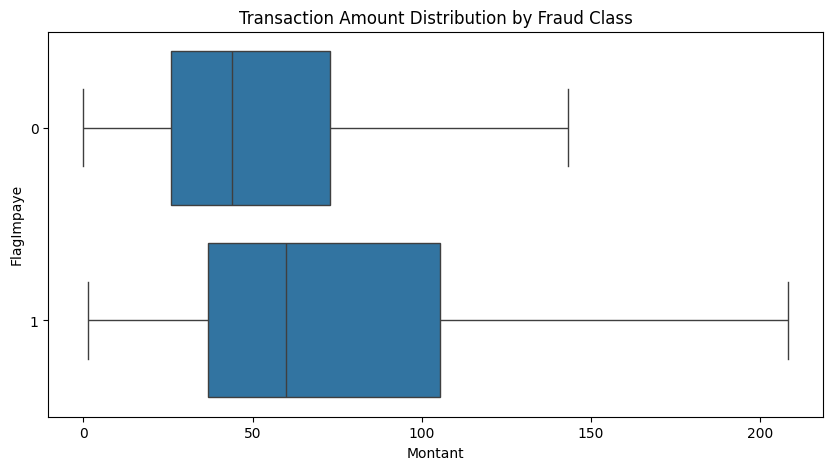

In [45]:
# Boxplot to visualize transaction amount distribution by fraud class
plt.figure(figsize=(10,5))
sns.boxplot(data, x="Montant", y="FlagImpaye", showfliers=False)
plt.title("Transaction Amount Distribution by Fraud Class")
plt.show()


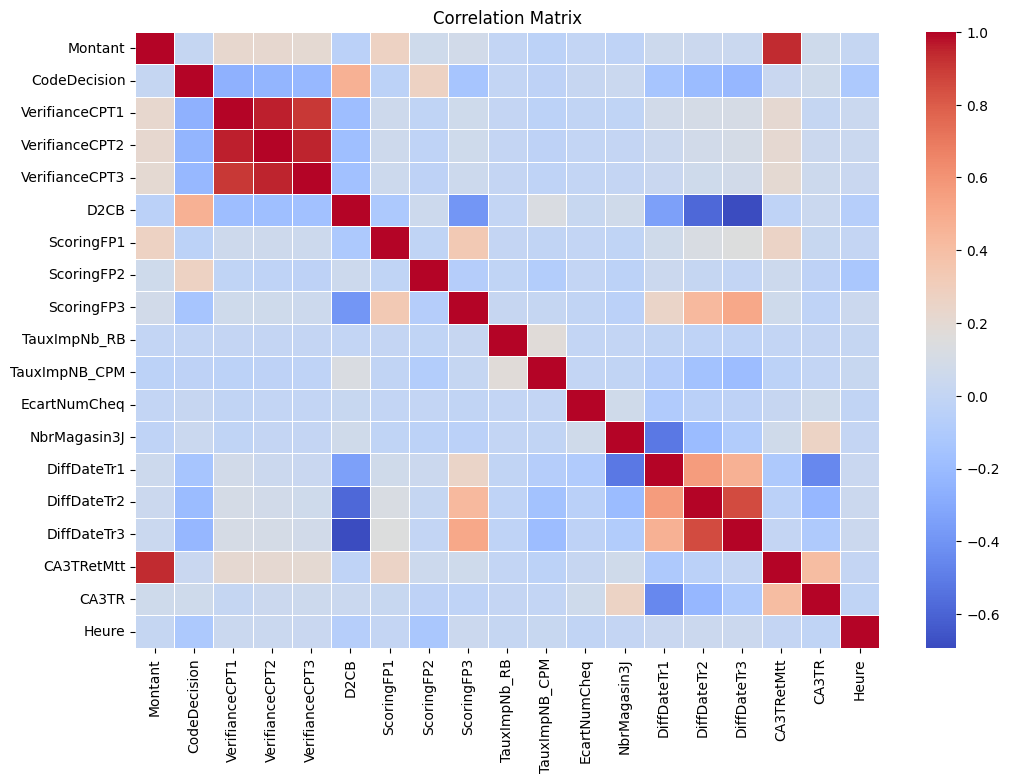

In [46]:

# Select only numeric columns
numeric_data = data.select_dtypes(include=["number"])

# Compute the correlation matrix
corr_matrix = numeric_data.corr()

# Plot the heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()



Feature-Specific Correlation Analysis

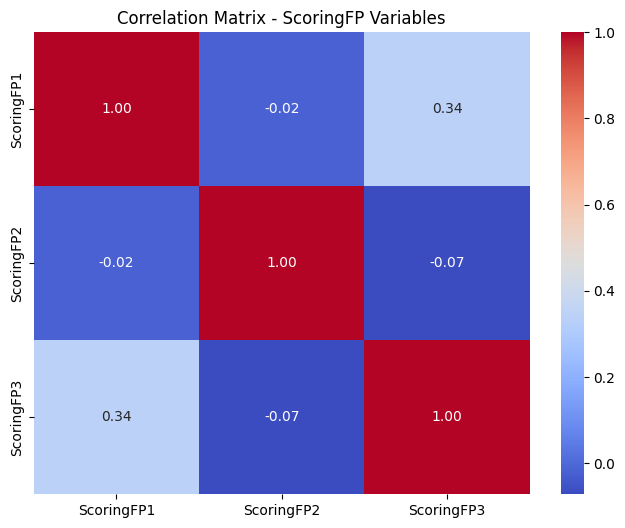

In [47]:
# Analyze correlation for ScoringFP variables
correlation_matrix = data[["ScoringFP1", "ScoringFP2", "ScoringFP3"]].corr()
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix - ScoringFP Variables")
plt.show()


None of these variables exhibit strong correlation, indicating that they are not redundant.

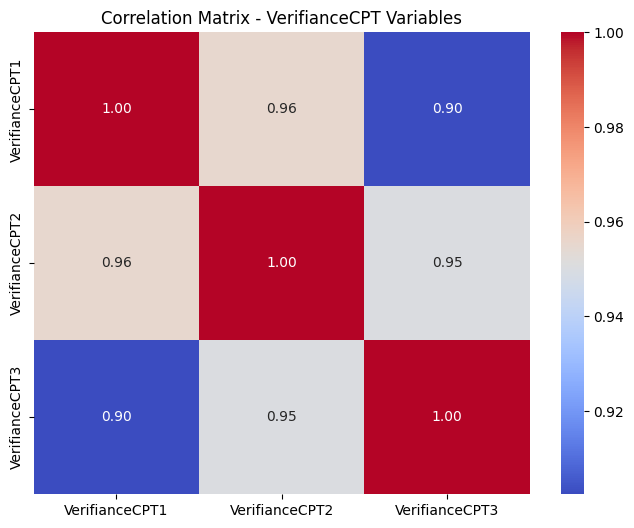

In [48]:
# Analyze correlation for VerifianceCPT variables
correlation_matrix = data[["VerifianceCPT1", "VerifianceCPT2", "VerifianceCPT3"]].corr()

plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix - VerifianceCPT Variables")
plt.show()


The three variables exhibit extremely strong correlations (> 0.9), making them redundant. Only VerifianceCPT2 is retained as it has the strongest correlation with the other two.

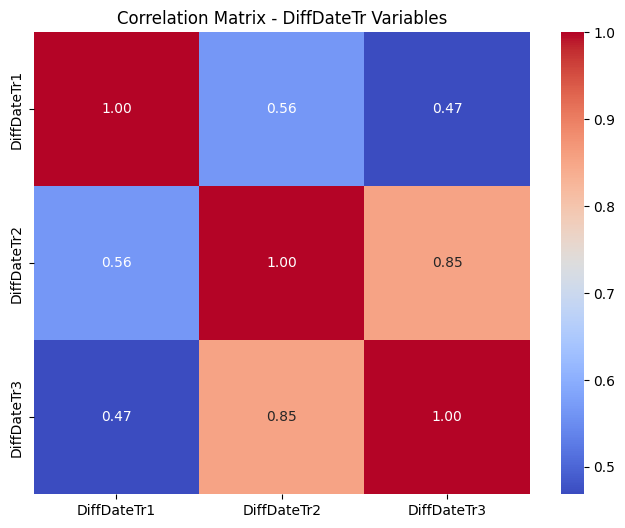

In [49]:
# Analyze correlation for DiffDateTr variables
correlation_matrix = data[["DiffDateTr1", "DiffDateTr2", "DiffDateTr3"]].corr()
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix - DiffDateTr Variables")
plt.show()


The correlation values indicate a strong correlation between DiffDateTr2 and DiffDateTr3 (0.85), suggesting redundancy, while DiffDateTr1 shows moderate (0.56) and weaker (0.47) correlations with DiffDateTr2 and DiffDateTr3, respectively. As a result, we will create a synthetic variable that combines them (median of the gaps).

conclusion

VerifianceCPT1, VerifianceCPT2, and VerifianceCPT3 are highly correlated, indicating they capture similar information (recent transaction counts), so we retain only VerifianceCPT2; DiffDateTr1 is correlated with DiffDateTr2, which has an even stronger correlation with DiffDateTr3, and all show an inverse correlation with D2CB, suggesting the creation of a synthetic variable, while CodeDecision is removed as it is post-transaction information.

Feature Engineering & Selection

In [50]:
# Create a synthetic feature (MedianDiffDate)
data["MedianDiffDate"] = data[["DiffDateTr1", "DiffDateTr2", "DiffDateTr3"]].median(axis=1)
# Create a synthetic feature (MedianDiffDate)
train_df["MedianDiffDate"] = train_df[["DiffDateTr1", "DiffDateTr2", "DiffDateTr3"]].median(axis=1)
test_df["MedianDiffDate"] = test_df[["DiffDateTr1", "DiffDateTr2", "DiffDateTr3"]].median(axis=1)
# Drop redundant features
cols_to_drop = ["VerifianceCPT3", "VerifianceCPT1", "CodeDecision", "DiffDateTr1", "DiffDateTr2", "DiffDateTr3"]

data = data.drop(columns=cols_to_drop)
train_df = train_df.drop(columns=cols_to_drop)
test_df = test_df.drop(columns=cols_to_drop)

In [51]:
data.shape

(4646773, 18)

Create a Weekend Indicator

In [52]:
# Create IsWeekend feature (1 if transaction occurred on a weekend)
data["DateTransaction"] = pd.to_datetime(data["DateTransaction"])
train_df["DateTransaction"] = pd.to_datetime(train_df["DateTransaction"])
test_df["DateTransaction"] = pd.to_datetime(test_df["DateTransaction"])

data["IsWeekend"] = data["DateTransaction"].dt.weekday.isin([5, 6]).astype(int)
train_df["IsWeekend"] = train_df["DateTransaction"].dt.weekday.isin([5, 6]).astype(int)
test_df["IsWeekend"] = test_df["DateTransaction"].dt.weekday.isin([5, 6]).astype(int)

# Drop DateTransaction feature
data = data.drop(columns=["DateTransaction"])
train_df = train_df.drop(columns=["DateTransaction"])
test_df = test_df.drop(columns=["DateTransaction"])


In [53]:
data["IsWeekend"].value_counts() 

IsWeekend
0    3532322
1    1114451
Name: count, dtype: int64

Statistical Tests for Feature Selection

1.Mann-Whitney U Test



In [54]:
from scipy.stats import mannwhitneyu

# Separate fraudulent and non-fraudulent transactions
fraud = data[data["FlagImpaye"] == "1"]
non_fraud = data[data["FlagImpaye"] == "0"]

# Select numeric columns
numeric_columns = data.select_dtypes(include=["number"]).columns

# Apply Mann-Whitney U Test
mw_results = {col: mannwhitneyu(fraud[col].dropna(), non_fraud[col].dropna(), alternative='two-sided')
              for col in numeric_columns}

# Convertir les résultats en DataFrame
mw_df = pd.DataFrame({col: [t.statistic, t.pvalue] for col, t in mw_results.items()}, index=["U-Statistic", "P-Value"]).T



In [55]:
mw_df

,U-Statistic,P-Value
Montant,8.593470e+10,0.000000e+00
VerifianceCPT2,8.099590e+10,0.000000e+00
D2CB,5.099713e+10,0.000000e+00
ScoringFP1,8.010811e+10,0.000000e+00
ScoringFP2,4.552209e+10,0.000000e+00
ScoringFP3,8.368245e+10,0.000000e+00
TauxImpNb_RB,8.879129e+10,0.000000e+00
TauxImpNB_CPM,8.369809e+10,0.000000e+00
EcartNumCheq,7.533116e+10,0.000000e+00
NbrMagasin3J,7.139551e+10,3.848679e-181


At first glance, all variables should be retained.

Kolmogorov-Smirnov (KS) Test

In [56]:
from scipy.stats import ks_2samp

# Apply Kolmogorov-Smirnov Test
ks_results = {col: ks_2samp(fraud[col].dropna(), non_fraud[col].dropna())
              for col in numeric_columns}

# Convertir les résultats en DataFrame
ks_df = pd.DataFrame({col: [t.statistic, t.pvalue] for col, t in ks_results.items()}, index=["KS-Statistic", "P-Value"]).T

# Afficher les résultats
print(ks_df)


                KS-Statistic        P-Value
Montant             0.176071   0.000000e+00
VerifianceCPT2      0.156553   0.000000e+00
D2CB                0.236557   0.000000e+00
ScoringFP1          0.184299   0.000000e+00
ScoringFP2          0.265630   0.000000e+00
ScoringFP3          0.218500   0.000000e+00
TauxImpNb_RB        0.199074   0.000000e+00
TauxImpNB_CPM       0.144128   0.000000e+00
EcartNumCheq        0.082808  3.224861e-178
NbrMagasin3J        0.030928   3.369264e-25
CA3TRetMtt          0.200958   0.000000e+00
CA3TR               0.091028  2.474214e-215
Heure               0.088658  2.879373e-204
MedianDiffDate      0.061802   2.158435e-99
IsWeekend           0.009637   7.837514e-03


Feature Importance Analysis (Random Forest)

In [26]:
from sklearn.ensemble import RandomForestClassifier

# Prepare dataset
X = data.drop(columns=["FlagImpaye", "IDAvisAutorisationCheque", "ZIBZIN"]) 
y = data["FlagImpaye"]


# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importance
feature_importance = pd.DataFrame({"Feature": X.columns, "Importance": rf.feature_importances_})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)




C:\Users\MSI\AppData\Local\Temp\ipykernel_25096\4209931240.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance["Importance"], y=feature_importance["Feature"], palette="viridis")


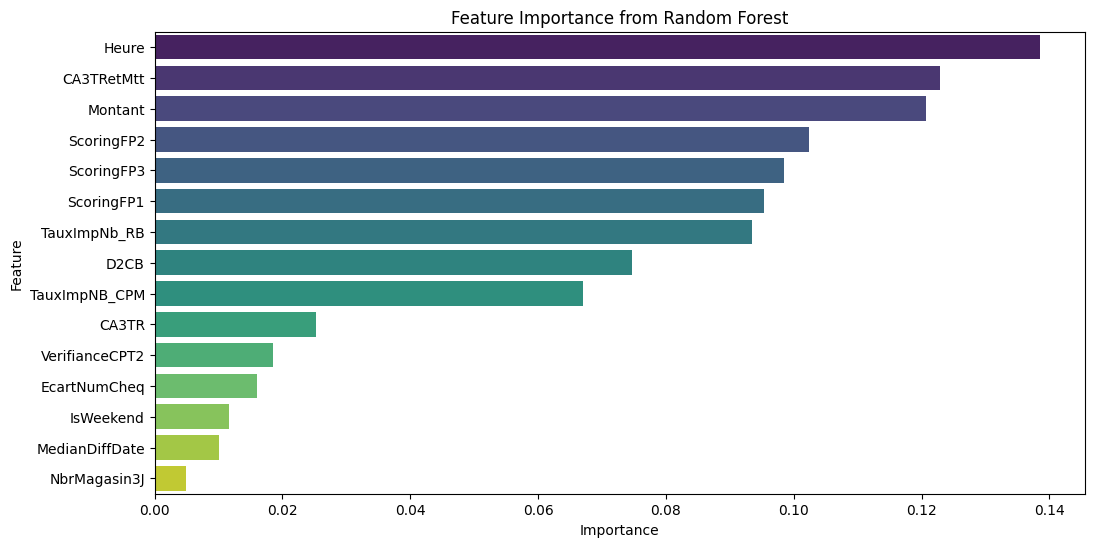

In [27]:
# Plot feature importance
plt.figure(figsize=(12,6))
sns.barplot(x=feature_importance["Importance"], y=feature_importance["Feature"], palette="viridis")
plt.title("Feature Importance from Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

Information Gain Analysis

In [57]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

# Compute Information Gain
ig_values = mutual_info_classif(X, y, discrete_features=False)

# Create DataFrame
ig_df = pd.DataFrame({"Variable": X.columns, "Information Gain": ig_values})
ig_df = ig_df.sort_values(by="Information Gain", ascending=False)

print(ig_df)


          Variable  Information Gain
13  MedianDiffDate          0.267713
1   VerifianceCPT2          0.056934
14       IsWeekend          0.054425
9     NbrMagasin3J          0.051252
7    TauxImpNB_CPM          0.033941
2             D2CB          0.012449
6     TauxImpNb_RB          0.006476
5       ScoringFP3          0.004342
4       ScoringFP2          0.004242
3       ScoringFP1          0.003431
10      CA3TRetMtt          0.002525
0          Montant          0.002242
12           Heure          0.001465
11           CA3TR          0.000869
8     EcartNumCheq          0.000423


Final Feature Selection

Based on the conducted analyses, we decided to remove the variables NbrMagasin3J, EcartNumCheq, CA3TR, IsWeekend, and MedianDiffDate, with some uncertainty regarding MedianDiffDate and VerifianceCPT2, which will be tested both with and without them.

In [58]:
# Based on previous analysis, we remove low-importance features
cols_to_remove = ["ZIBZIN", "IDAvisAutorisationCheque","NbrMagasin3J", "EcartNumCheq", "CA3TR", "IsWeekend", "MedianDiffDate"]
all_data = data.copy()
data = data.drop(columns=cols_to_remove)
train_df = train_df.drop(columns=cols_to_remove)
test_df = test_df.drop(columns=cols_to_remove)

In [59]:
print("\n🔹 Final dataset shape after feature selection: ", data.shape)



🔹 Final dataset shape after feature selection:  (4646773, 11)


In [60]:
data.columns

Index(['FlagImpaye', 'Montant', 'VerifianceCPT2', 'D2CB', 'ScoringFP1',
       'ScoringFP2', 'ScoringFP3', 'TauxImpNb_RB', 'TauxImpNB_CPM',
       'CA3TRetMtt', 'Heure'],
      dtype='object')

In [61]:
X_train = train_df.drop(columns=["FlagImpaye"])
y_train = train_df["FlagImpaye"]

In [62]:
X_test = test_df.drop(columns=["FlagImpaye"])
y_test = test_df["FlagImpaye"]

In [63]:
X_train.shape

(3888468, 10)

In [64]:
X_test.shape

(747411, 10)

Undersampling dataset

In [38]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)